In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
import redis

In [3]:
cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

In [4]:
r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

In [5]:
# redis keys
KOSPI_TICKERS = 'KOSPI_TICKERS'
KOSDAQ_TICKERS = 'KOSDAQ_TICKERS'

KOSPI_OHLCV = 'KOSPI_OHLCV'
KOSDAQ_OHLCV = 'KOSDAQ_OHLCV'

KOSPI_VOL = 'KOSPI_VOL'
KOSDAQ_VOL = 'KOSDAQ_VOL'

In [6]:
kp_tickers = [ticker.decode() for ticker in r.lrange(KOSPI_TICKERS, 0 ,-1)]
kd_tickers = [ticker.decode() for ticker in r.lrange(KOSDAQ_TICKERS, 0 ,-1)]
tickers = kp_tickers + kd_tickers

In [7]:
agents = ['private', 'forgn', 'inst_sum', 'etc_inst', 'trust', 'pension']

In [8]:
key = tickers[0] + '_BUYSELL'
df = pd.read_msgpack(r.get(key))

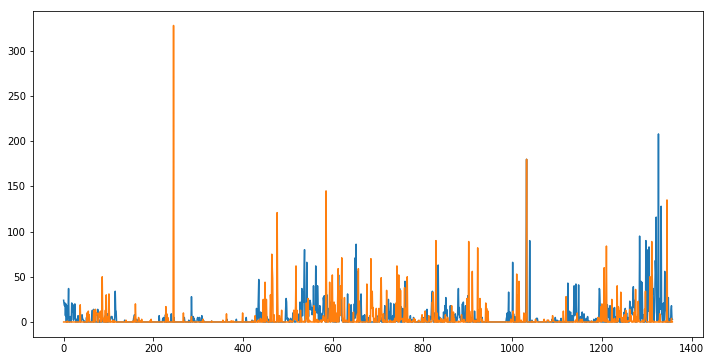

In [11]:
plt.plot(df['etc_inst_b'])
plt.plot(df['etc_inst_s'])
plt.show()

In [19]:
net_columns = ['{}_n'.format(agent) for agent in agents]
cumsum = df[net_columns].cumsum()
possession = cumsum + cumsum.apply(lambda col: abs(min(col))) # 주체별 보유 주식수
total_stock_num = possession.loc[:, :].sum(axis=1) # 전체 유통 주식수

# 0 제거
possession = possession.replace(0, 1)
total_stock_num = total_stock_num.replace(0, 1)

# 영향력 계산
possession['total_stock_num'] = total_stock_num
power = possession.div(possession['total_stock_num'], axis='index')
possession.drop('total_stock_num', axis=1, inplace=True)
power.drop('total_stock_num', axis=1, inplace=True)

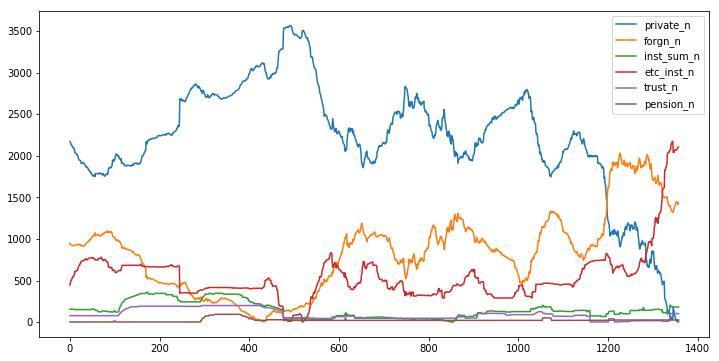

In [20]:
possession.plot()

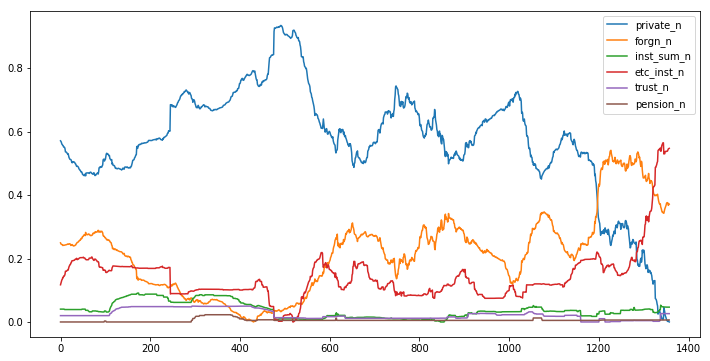

In [21]:
power.plot()

In [30]:
# 기관 순도 (institution purity)
# 기관(inst_sum) 순매수는 다양한 기관들의 매수, 매도를 더한 값이다
# 보통 많은 모든 기관을 고려 안 하고 투신(투자신탁, Trust Fund), 연기금(Pension Fund)만 고려한다.
#이들이 가장 많은 자본을 쥐고 있으며, 그들의 투자 결정에 주가가 영향을 받기 때문이다.
# 그래서 기관의 순도를 확인해야 하는데, 이는: (투신 보유량 + 연기금 보유량) / 기관 보유량
# institution_purity = (trust_n + pension_n) / inst_sum_n
institution_purity = (possession['trust_n'] + possession['pension_n']) / possession['inst_sum_n']

In [37]:
# 거래량을 모은 DataFrame을 불러온다
key = tickers[0] + '_BUYSELL'
df = pd.read_msgpack(r.get(key))

kp_vol = pd.read_msgpack(r.get(KOSPI_VOL))
kd_vol = pd.read_msgpack(r.get(KOSDAQ_VOL))

In [39]:
kd_vol

,000250,000440,001000,001540,001810,001840,002230,002290,002680,002800,...,900270,900280,900290,900300,900310,950110,950130,950140,950160,950170
2013-01-02,330.01,0.09,2.99,19.84,235.50,27.82,930.51,0.67,38.37,NaN,...,NaN,NaN,NaN,NaN,NaN,1645.80,NaN,NaN,NaN,NaN
2013-01-03,1125.59,0.25,1.96,18.67,254.91,75.40,529.76,0.02,44.08,NaN,...,NaN,NaN,NaN,NaN,NaN,2043.91,NaN,NaN,NaN,NaN
2013-01-04,364.02,0.17,1.43,17.86,327.18,57.24,580.21,0.04,74.49,NaN,...,NaN,NaN,NaN,NaN,NaN,7257.77,NaN,NaN,NaN,NaN
2013-01-07,487.54,0.02,0.82,14.87,332.03,31.17,256.21,0.06,60.72,NaN,...,NaN,NaN,NaN,NaN,NaN,1390.82,NaN,NaN,NaN,NaN
2013-01-08,1382.79,1.49,1.05,12.71,206.41,44.39,314.13,0.02,32.88,NaN,...,NaN,NaN,NaN,NaN,NaN,956.27,NaN,NaN,NaN,NaN
2013-01-09,462.72,0.23,0.56,13.55,291.82,600.56,1029.28,0.59,56.52,NaN,...,NaN,NaN,NaN,NaN,NaN,1076.31,NaN,NaN,NaN,NaN
2013-01-10,1220.80,0.11,0.57,4.35,130.39,183.34,708.79,0.24,1306.11,NaN,...,NaN,NaN,NaN,NaN,NaN,527.00,NaN,NaN,NaN,NaN
2013-01-11,585.71,0.13,2.66,13.22,213.34,88.64,322.61,0.11,259.76,NaN,...,NaN,NaN,NaN,NaN,NaN,735.72,NaN,NaN,NaN,NaN
2013-01-14,286.93,0.06,0.18,21.97,294.41,264.63,532.01,0.08,134.76,NaN,...,NaN,NaN,NaN,NaN,NaN,526.93,NaN,NaN,NaN,NaN
2013-01-15,1139.31,0.21,3.22,39.95,1284.31,109.37,669.03,0.02,123.53,NaN,...,NaN,NaN,NaN,NaN,NaN,605.12,NaN,NaN,NaN,NaN
